# Demonstration of Dynamic Network Weight Scaling Mechanism

## Basic Imports

In [31]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict

from ipywidgets import FloatText, HTML, Button, HBox, VBox

import sys
sys.path.append("..")

## Our Code Imports

In [ ]:
from mechanisms.percentage_allocation_weighted_plurality import PercentageAllocationWeightedPlurality
from mechanisms.simple_weighting_mechanism import SimpleCredentialWeightingMechanism

from metrics.plutocracy import calc_nakamoto_coefficient_additive

from utils.conversion import voter_cred_df_to_dict

## Background

* There are three *groups* of NFTS: Red, Blue, and Yellow.
* Within each group, there are two different types of NFTs, numbered 1 and 2. So there are $RED_1$, $RED_2$, $BLUE_1$, etc. 
* Each eligible voter holds at least one of these NFTs. 
* Overall, Red NFTs are rarest and represent the most value. Comparatively, Blue and Yellow NFTs are easier to get. 
* However, there is no requirement that the two types of NFTs within a given 
* The *cweight* of an individual credential is defined to be 
$cweight = \text{Number of Credential Holders} \times \text{Credential Weight}$.
* The *cweight* of a group of NFTs is just the sum of the *cweight* of each individual credential. 
* **Fundamental Property:** For this example, the cweights should satisfy:
$$ Red cweight \geq Blue cweight = Yellow cweight.$$ This reflects the greater insight of Red NFT holders in the community. 

## Accessing Credential Information

### Background 
To begin, we need data about the voters and their credentials (e.g. NFTs and tokens). 

This is input in the form of a .csv file with
* a column called `voter` that contains voter IDs (e.g. wallet addresses)
*  columns are **RED**, **BLUE**, and **YELLOW** 
* each entry is either 1 or 0, corresponding to ownership or non-ownership of the particular NFT. 

### Mechanics 
1. Make sure that this .ipynb file is in the same directory as the voter data. 
2. To use your own data, change the value of `VOTER_INFO_FILE` from `default_voter_data.csv` to the string of your own filename. 

In [2]:
# Code to read in a file 
# Change this line to change voter credential data. 
VOTER_INFO_FILE = "data/default_voter_data.csv"

In [3]:
# Read Initial Data From csv file
voter_cred_df = pd.read_csv(VOTER_INFO_FILE,
                             index_col = 'voter')

In [4]:
voter_cred_dict = voter_cred_df_to_dict(voter_cred_df)

## Assigning Initial Weights

One way to get started is to assign some initial weights to get the process started, to indicate domain expert knowledge of relative importance. 

By default, all weights are set equal to 1.0. To change this, type new values in the textbox. 

**NOTE:** The re-weighting will respect the initialrelative weights assigned within groups. For instance, if the initial weight of `red_1` is 3.0 and the initial weight of `red_2` is 2.0, the final weights will also have the ratio `red_1/red_2 = 1.5`. 

In [5]:

total_weight = 0

weights = {}
weights["red_1"] = FloatText(description='red_1', value=1.0, layout={'width': '200px'})
weights["blue_1"] = FloatText(description='blue_1', value=1.0, layout={'width': '200px'})
weights["yellow_1"] = FloatText(description='yellow_1', value=1.0, layout={'width': '200px'})
weights["red_2"] = FloatText(description='red_2', value=1.0, layout={'width': '200px'})
weights["blue_2"] = FloatText(description='blue_2', value=1.0, layout={'width': '200px'})
weights["yellow_2"] = FloatText(description='yellow_2', value=1.0, layout={'width': '200px'})
total_weight_widget = HTML(value=f"Total weight: {total_weight}")



def update_total_weight(b):
    total_weight = sum(weight.value for weight in weights.values())
    total_weight_widget.value = f"Total weight: {total_weight}"

# Add a title for the widget box
title_widget = HTML(value="<h2> Assign Initial Weights Below </h2>")

# Create two columns for weights
weights_column_1 = VBox([weights["red_1"], weights["blue_1"], weights["yellow_1"]])
weights_column_2 = VBox([weights["red_2"], weights["blue_2"], weights["yellow_2"]])  # This column is intentionally left empty to maintain the two-column layout
weights_columns = HBox([weights_column_1, weights_column_2])

# Create a box for the update button and total weight display
update_total_weight_box = VBox([Button(description="Update Total Weight", on_click=update_total_weight), HTML(value="Total weight:")])

# Combine the weights columns and the update box
combined_widget_box = VBox([title_widget, weights_columns, update_total_weight_box])
display(combined_widget_box)

# TODO: Make it so the total weight value updates on the button click. 
# TODO: Add a table summarizing relative weights. 

In [6]:
initial_cred_weights = {key: weights.get(key).value
                              for key in weights.keys()}

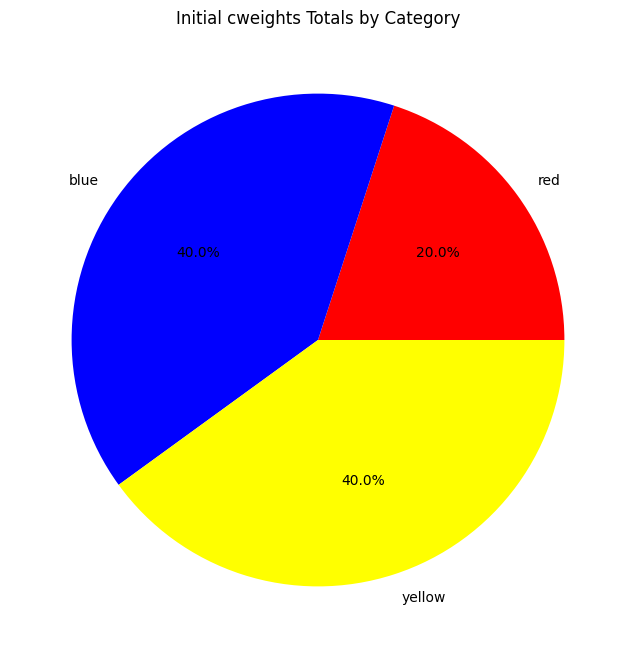

In [9]:
def calculate_cweight_totals(color_creds, initial_cweights):
    return {
        color: initial_cweights[creds].sum() for color, creds in color_creds.items()
    }

# Example usage
color_creds = {
    "red": ["red_1", "red_2"],
    "blue": ["blue_1", "blue_2"],
    "yellow": ["yellow_1", "yellow_2"]
}

initial_cweights_totals = calculate_cweight_totals(color_creds, initial_cweights)

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'yellow']
plt.pie(initial_cweights_totals.values(), labels=initial_cweights_totals.keys(), autopct='%1.1f%%', colors=colors)
plt.title('Initial cweights Totals by Category')
plt.show()

In [10]:
def calculate_voter_weights(voter_cred_df, weights):
    """
    Calculate the total weight of each voter based on their credentials and the weights assigned to each credential.

    Parameters:
    - voter_cred_df (DataFrame): A DataFrame where each row represents a voter and each column represents a credential.
    - weights (dict): A dictionary where each key is a credential and the value is the weight assigned to that credential.

    Returns:
    - Series: A Series where each index is a voter and the value is their total weight.
    """
    # Initialize a Series to store the total weight of each voter
    voter_weights = pd.Series(index=voter_cred_df.index)
    
    # Iterate over each voter
    for voter in voter_cred_df.index:
        # Initialize the total weight for the current voter
        total_weight = 0
        
        # Iterate over each credential of the current voter
        for credential, value in voter_cred_df.loc[voter].items():
            # Add the weighted value of the credential to the total weight
            total_weight += value * weights.get(credential).value
        
        # Store the total weight of the voter
        voter_weights[voter] = total_weight
    
    return voter_weights


In [11]:
initial_voter_weights = calculate_voter_weights(voter_cred_df, weights)

## Re-weighting to Achieve Desired Properties 

For the time being, we could set a single example set of requirements: RED >= YELLOW >= BLUE.
Moving towards more arbitrary requirements is for future work. 

In [13]:
#TODO: Move to utils
# 

def reweight_color_creds(initial_voter_data: pd.DataFrame,
                         initial_weights_dict: Dict[str, float],
                         verbose = False):
    """
    This is a specific implementation for demonstration purposes.
    """

    final_voter_data = initial_voter_data.copy(deep=True)
    final_weights_dict = {}

    init_blue_cweight = initial_voter_data['blue_1'].sum() + initial_voter_data['blue_2'].sum()
    init_yellow_cweight = initial_voter_data['yellow_1'].sum() + initial_voter_data['yellow_2'].sum()
    init_red_cweight = initial_voter_data['red_1'].sum() + initial_voter_data['red_2'].sum()

    #We won't be re-scaling blue, regardless. 
    final_blue_cweight = init_blue_cweight
    final_weights_dict["blue_1"] = initial_weights_dict.get("blue_1")
    final_weights_dict["blue_2"] = initial_weights_dict.get("blue_2")

    if init_yellow_cweight >= final_blue_cweight:
        # If yellow already exceeds blue, keep everything same. 
        yellow_blue_scaling_factor = 1.0
        final_yellow_cweight = init_yellow_cweight

    else:
        # If blue exceeds yellow, we scale up the weight of the yellows. 
        yellow_blue_scaling_factor = final_blue_cweight/init_yellow_cweight
        
    final_weights_dict["yellow_1"] = yellow_blue_scaling_factor * initial_weights_dict.get("yellow_1")
    final_weights_dict["yellow_2"] = yellow_blue_scaling_factor * initial_weights_dict.get("yellow_2")
    final_voter_data["yellow_1"] = yellow_blue_scaling_factor * initial_weights_dict.get("yellow_1")
    final_voter_data["yellow_2"] = yellow_blue_scaling_factor * initial_weights_dict.get("yellow_2")
    final_yellow_cweight =  final_voter_data["yellow_1"].sum() + final_voter_data["yellow_2"].sum()

    # Check to see that things work as expected
    yellow_at_least_blue_check = (final_yellow_cweight >= final_blue_cweight)
    yellow_at_least_blue_msg = "The final yellow cweight should be greater than the final blue cweight."
    assert yellow_at_least_blue_check, yellow_at_least_blue_msg

    if init_red_cweight >= final_yellow_cweight:
        # If red already exceeds yellow, keep everything same. 
        red_yellow_scaling_factor = 1.0

    else:
        # If re-scaled yellow exceeds initial red, we need to re-scale red. 
        red_yellow_scaling_factor = final_yellow_cweight/init_red_cweight

    final_weights_dict["red_1"] = red_yellow_scaling_factor * initial_weights_dict.get("red_1")
    final_weights_dict["red_2"] = red_yellow_scaling_factor * initial_weights_dict.get("red_2")
    final_voter_data["red_1"] =  red_yellow_scaling_factor * initial_voter_data["red_1"]
    final_voter_data["red_2"] = red_yellow_scaling_factor * initial_voter_data["red_2"]
    final_red_cweight = final_voter_data["red_1"].sum() + final_voter_data["red_2"].sum()

    # Check to see that things work as expected
    red_at_least_yellow_check = (final_red_cweight >= final_yellow_cweight)
    red_at_least_yellow__msg = "The final yellow cweight should be greater than the final blue cweight."
    assert red_at_least_yellow_check, red_at_least_yellow__msg

    if verbose:
        print(f"Original blue cweight was: {init_blue_cweight}.")
        print(f"Original yellow cweight was: {init_yellow_cweight}.")
        print(f"Original red cweight is {init_red_cweight}.")

        print(f"Yellow credentials were scaled by a factor of: {yellow_blue_scaling_factor}.")
        print(f"Red credentials were scaled by a factor of: {red_yellow_scaling_factor}.")

        print(f"Final blue cweight is: {final_blue_cweight}.")
        print(f"Final yellow cweight is: {final_yellow_cweight}.")
        print(f"Final red cweight is: {final_red_cweight}.")

    return final_weights_dict, final_voter_data

In [14]:
final_cred_weights_dict, final_voter_info_data = reweight_color_creds(initial_voter_data=voter_cred_df,
                                         initial_weights_dict=initial_cred_weights)

Original blue cweight was: 4.
Original yellow cweight was: 4.
Original red cweight is 2.
Yellow credentials were scaled by a factor of: 1.0.
Red credentials were scaled by a factor of: 5.0.
Final blue cweight is: 4.
Final yellow cweight is: 10.0.
Final red cweight is: 10.0.


In [35]:
#TODO: Consider changing the calculation above to 

color_credential_list = ["red_1","red_2","blue_1","blue_2","yellow_1","yellow_2"]
initial_cred_weights = {key: weights.get(key).value for key in weights.keys()}

initial_weighting_mechanism = SimpleCredentialWeightingMechanism(credentials = color_credential_list,
                                                            credential_weights = initial_cred_weights)

final_weighting_mechanism = SimpleCredentialWeightingMechanism(credentials = color_credential_list,
                                                            credential_weights = final_cred_weights_dict)

In [36]:
initial_voter_weights = initial_weighting_mechanism.calc_voter_weights(voters=voter_cred_dict)
final_voter_weights = final_weighting_mechanism.calc_voter_weights(voters=voter_cred_dict)

In [40]:
initial_weight_distribution = [voter.get("weight") for _,voter in initial_voter_weights.items()]
final_weight_distribution = [voter.get("weight") for _,voter in final_voter_weights.items()]

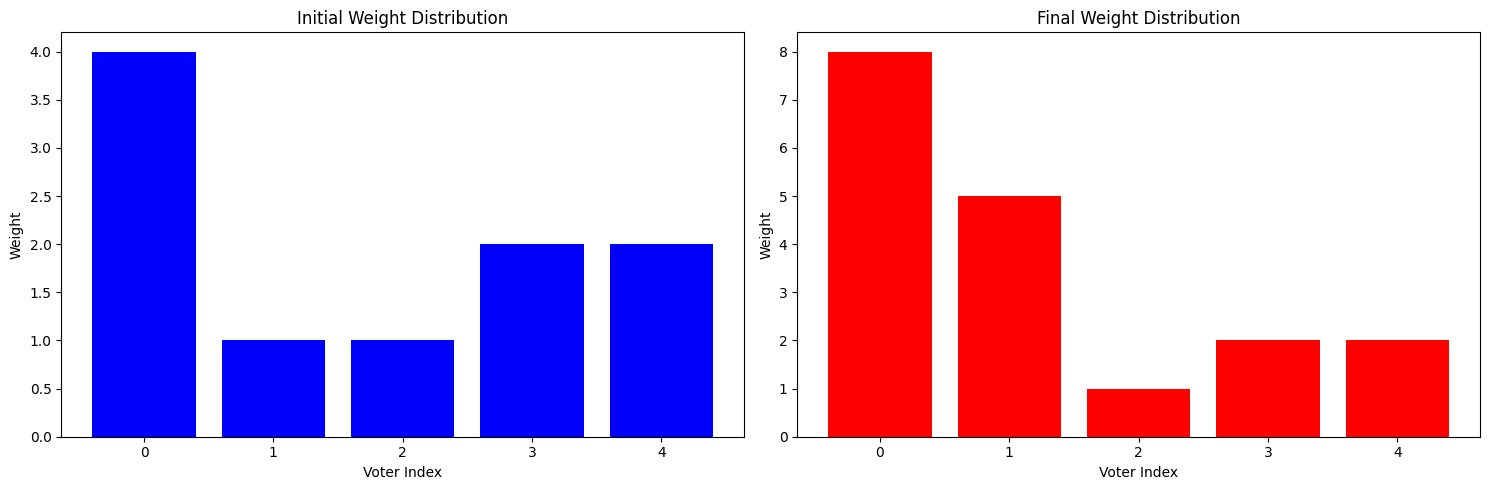

In [43]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting initial weight distribution
axs[0].bar(range(len(initial_weight_distribution)), initial_weight_distribution, color='blue')
axs[0].set_title('Initial Weight Distribution')
axs[0].set_xlabel('Voter Number')
axs[0].set_ylabel('Weight')

# Plotting final weight distribution
axs[1].bar(range(len(final_weight_distribution)), final_weight_distribution, color='red')
axs[1].set_title('Final Weight Distribution')
axs[1].set_xlabel('Voter Number')
axs[1].set_ylabel('Weight')

# Adjust layout to make room for titles
plt.tight_layout()

# Show the plots
plt.show()


In [51]:
# Plot Initial Weights

initial_cweight_values = np.array([voter_cred_df[col].sum() * initial_cred_weights.get(col) 
                  for col in voter_cred_df.columns])
final_cweight_values = np.array([voter_cred_df[col].sum() * final_cred_weights_dict.get(col) 
                  for col in voter_cred_df.columns])
cred_names = list(voter_cred_df.columns)

initial_cweights = pd.Series(
    initial_cweight_values, index=cred_names
).sort_values(ascending=True)

final_cweights = pd.Series(
    final_cweight_values, index=cred_names
).sort_values(ascending=True)

# Create a DataFrame with credential names as index and initial and final weights as columns
weight_comparison_df = pd.DataFrame({
    'Initial cweight': initial_cweight_values,
    'Final cweight': final_cweight_values
}, index=cred_names)


Text(0.5, 1.0, 'Comparison of Initial and Final cweight')

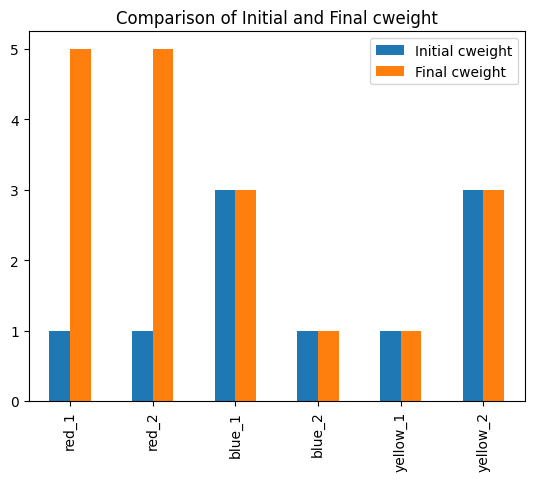

In [53]:
weight_comparison_df.plot(kind="bar")
plt.title("Comparison of Initial and Final cweight")

## Visualizing Impact of Re-weighting


## Choosing a Voting Mechanism

The properties of the voting are sensitive to the **aggregation rule** (vote processing rule) that turns ballots into winners, based on voter weights, as much as they are voter weights.

For the time being we assume rules possess **monotonicity**. 
In the example we use a simple percentage allocation mechanism. 

In [24]:
voting_mechanism = PercentageAllocationWeightedPlurality()

## Visualizing Metrics

In [26]:

calc_nakamoto_coefficient_additive(final_voter_weights_dict)

2

In [27]:
from utils.sampling import samples_voting_population_by_pct_range


In [28]:
# Demonstration of how the sampling works. 

NUM_SAMPLES = 10
MIN_PCT = 0.25
MAX_PCT = 0.75

final_voter_population_samples = samples_voting_population_by_pct_range(input_dict = final_voter_weights_dict,
                                       num_samples = NUM_SAMPLES,
                                       min_pct = MIN_PCT,
                                       max_pct = MAX_PCT)

In [29]:
final_nakamoto_coefficients = [calc_nakamoto_coefficient_additive(sample) for sample in voter_population_samples]

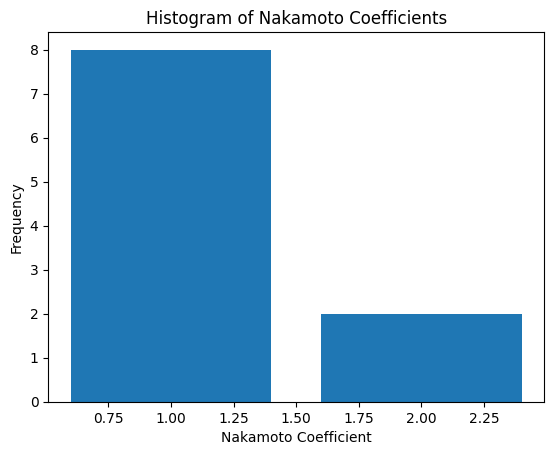

In [32]:
plt.hist(nakamoto_coefficients, bins=range(1, max(nakamoto_coefficients)+2), align='left', rwidth=0.8)
plt.title('Histogram of Nakamoto Coefficients')
plt.xlabel('Nakamoto Coefficient')
plt.ylabel('Frequency')
plt.show()